In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, TensorDataset

In [2]:
def trainer(model, criterion, optimizer, dataloader, epochs=5):
    """Simple training wrapper for PyTorch network."""
    
    train_loss = []
    for epoch in range(epochs):  # for each epoch
        losses = 0
        for X, y in dataloader:  # for each batch
            optimizer.zero_grad()       # Zero all the gradients w.r.t. parameters
            y_hat = model(X).flatten()  # Forward pass to get output
            loss = criterion(y_hat, y)  # Calculate loss based on output
            loss.backward()             # Calculate gradients w.r.t. parameters
            optimizer.step()            # Update parameters
            losses += loss.item()       # Add loss for this batch to running total
        train_loss.append(losses / len(dataloader))  # loss = total loss in epoch / number of batches = loss per batch
    return train_loss

In [3]:
class network(torch.nn.Module):
    def __init__(self):
        super(network, self).__init__()

        self.activation = torch.nn.ReLU()
        # self.activation = torch.nn.Hardsigmoid()
        
        self.linear1 = torch.nn.Linear(2, 10)
        self.linear2 = torch.nn.Linear(10, 10)
        
        self.output = torch.nn.Linear(10, 1)
        # self.softmax = torch.nn.Softmax()

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.activation(x)
        x = self.output(x)
        return x

In [4]:
def f(x, model):
    x = torch.tensor(x, dtype=torch.float32)
    return model(x).detach().numpy().ravel()

def f_derive(x, model):
    x = torch.tensor(x, dtype=torch.float32)
    
    # Calculate dummy gradients
    model.zero_grad()
    model(x).backward()
    grads = []
    for param in model.parameters():
        grads.append(param.grad.view(-1))
    grads = torch.cat(grads)
    return grads.detach().numpy()

def score(x, y, model):
    return np.abs(y-f(x, model))

def score_deriv(x, y, model):
    return -np.sign(y - f(x, model))*f_derive(x, model)

In [5]:
epsi = .1
def Tau_e(y, epsi=epsi):
    gamma = 15/16*(-1/5*(y/epsi)**5 + 2/3*(y/epsi)**3 - (y/epsi) + 8/15)
    return gamma*(y >= -epsi)*(y < epsi) + 1*(y<=-epsi)

def Tau_e_deriv(y, epsi=epsi):
    gamma_deriv = 15/16*(epsi**2-y**2)**2/epsi**5
    return gamma_deriv*(y >= -epsi)*(y < epsi)

def linear_quantile_smooth_gd(X, y, model, alpha = .1, stepsize = 0.01, n_iter = 10000, epsi = .1):

    X_tilde = np.concatenate((np.ones((X.shape[0],1)),X), axis = 1)
    optim_track = np.zeros(n_iter)
    
    for t in np.arange(n_iter):
        
        weights = []
        for param in model.parameters():
            weights.append(param.view(-1).detach().numpy())

        scores = score(X_tilde, y, model)
        k = int(np.ceil( (len(scores) + 1)*(1-alpha) ))
        quant = np.sort(scores)[k-1]
        
        s1 = 0
        s2 = 0
        for i in range(len(scores)):
            a = Tau_e_deriv(scores[i] - quant, epsi)
            s1 += a * score_deriv(X_tilde[i], y[i], model)
            s2 += a
        grad = s1/s2

        with torch.no_grad():  
            i = 0
            sss = 0
            for param in model.parameters():
                param.data = torch.tensor(param.data - stepsize[t]*grad[sss:sss+len(weights[i])].reshape((param.size())), dtype=torch.float32)
                sss += len(weights[i])
                i += 1
        optim_track[t] = np.linalg.norm(grad)

    return model, optim_track   

In [6]:
np.random.seed(0)

n = 2000
ntest = 1000

# ====================
X = np.random.normal(size=n)
ber = np.random.binomial(size=n, n=1, p= 0.95)
Y = np.sin(X) + ber*np.random.normal(0, .1, n) + (1-ber)*np.random.normal(4, .1, n)
# ====================

# ====================
Xtrain = X[:n//2]
Xcalib = X[n//2:]

ytrain = Y[:n//2]
ycalib = Y[n//2:]
# ====================

Xtest = np.random.normal(size=ntest)
ber_test = np.random.binomial(size=ntest, n=1, p= 0.95)
ytest = np.sin(Xtest) + ber_test*np.random.normal(0, .1, ntest) + (1-ber_test)*np.random.normal(4, .1, ntest)

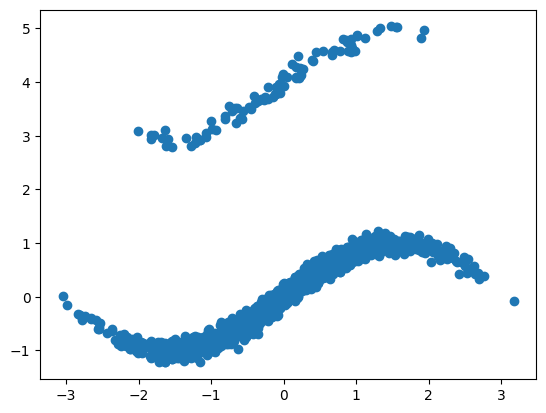

In [7]:
plt.scatter(X, Y)

In [8]:
model = network()  # make an instance of our network

# Smooth quantile

In [9]:
n_iter = 300

stepsize = np.arange(1, n_iter+1)**(-.6)
alpha = .1
epsi = .1

XXtrain = np.sin(Xtrain).reshape((-1, 1))
model_smooth, opt_track = linear_quantile_smooth_gd(XXtrain, ytrain, model, alpha, stepsize, n_iter, epsi)

/tmp/ipykernel_18363/3945096564.py:37: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  param.data = torch.tensor(param.data - stepsize[t]*grad[sss:sss+len(weights[i])].reshape((param.size())), dtype=torch.float32)
/tmp/ipykernel_18363/3945096564.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  param.data = torch.tensor(param.data - stepsize[t]*grad[sss:sss+len(weights[i])].reshape((param.size())), dtype=torch.float32)


In [10]:
plt.plot(opt_track)

In [11]:
XXcalib = np.sin(Xcalib).reshape((-1, 1))
scores_smooth = score(np.concatenate((np.ones((XXcalib.shape[0], 1)), XXcalib), axis = 1), ycalib, model_smooth)

In [12]:
k = int(np.ceil( (len(scores_smooth) + 1)*(1-alpha) ))
q_smooth = np.sort(scores_smooth)[k-1]

In [13]:
XXtest = np.sin(Xtest).reshape((-1, 1))
ytest_smooth = f(np.concatenate((np.ones((XXtest.shape[0],1)), XXtest), axis = 1), model_smooth)

print(2*q_smooth, np.mean( (ytest <= (ytest_smooth+q_smooth))*(ytest >= (ytest_smooth-q_smooth)) ))

0.4662808836948664 0.887


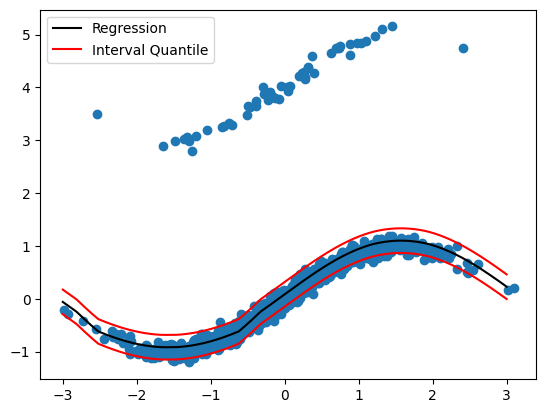

In [14]:
xplot = np.linspace(-3, 3, 10000)
yplot_smooth = f(np.concatenate((np.ones((np.sin(xplot).reshape((-1, 1)).shape[0],1)),
                                          np.sin(xplot).reshape((-1, 1))), axis = 1), model_smooth)

plt.plot(xplot, yplot_smooth, color='black',linestyle='-')
plt.plot(xplot, yplot_smooth + q_smooth, color='r',linestyle='-')
plt.plot(xplot, yplot_smooth - q_smooth, color='r',linestyle='-')
plt.scatter(Xtest, ytest)

plt.legend(['Regression','Interval Quantile'])

# Standard training of NN

In [15]:
class network_old(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden = torch.nn.Linear(input_size, hidden_size)
        self.output = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.hidden(x)
        x = torch.sigmoid(x)
        x = self.output(x)
        return x

In [16]:
model_old = network_old(2, 3, 1)
Xtraintorch = torch.tensor(np.concatenate((np.ones((XXtrain.shape[0], 1)), XXtrain), axis = 1), dtype=torch.float32)
ytraintorch = torch.tensor(ytrain, dtype=torch.float32)
dataloader = DataLoader(TensorDataset(Xtraintorch, ytraintorch), batch_size=1, shuffle=True)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model_old.parameters(), 0.1)
train_loss = trainer(model_old, criterion, optimizer, dataloader, epochs=101)

In [18]:
scores_old = score(np.concatenate((np.ones((XXcalib.shape[0], 1)), XXcalib), axis = 1), ycalib, model_old)
k = int(np.ceil( (len(scores_old) + 1)*(1-alpha) ))
q_old = np.sort(scores_old)[k-1]

In [19]:
xplot = np.linspace(-3, 3, 10000)
yplot_old = f(np.concatenate((np.ones((np.sin(xplot).reshape((-1, 1)).shape[0],1)),
                                          np.sin(xplot).reshape((-1, 1))), axis = 1), model_old)

plt.plot(xplot, yplot_old, color='black',linestyle='-')
plt.plot(xplot, yplot_old + q_old, color='r',linestyle='-')
plt.plot(xplot, yplot_old - q_old, color='r',linestyle='-')
plt.scatter(Xtest, ytest)

plt.legend(['Regression','Interval Quantile'])